In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('..')

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import utils.nn as tu
import utils.vis as vis
import utils.mp as mp

from tqdm.auto import trange

T.__version__

'1.3.1'

 > Custom Module                          | 0,377,781
 >             criterion: MSELoss         |         0
 >                   net: Sequential      |   377,781



torch.Size([16, 3, 32, 32])

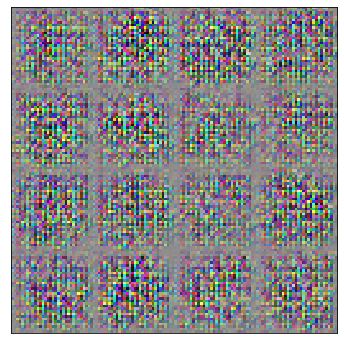

In [3]:
class MsgEncoder(tu.Module):
    def __init__(self, msg_size, img_channels):
        super().__init__()

        self.net = nn.Sequential(
            tu.reshape(-1, msg_size, 1, 1),
            tu.deconv_block(32 , 128         , ks=5, s=2, p=1),
            nn.Dropout(0.2),
            tu.deconv_block(128, 64          , ks=5, s=1, p=2),
            nn.Dropout(0.5),
            tu.deconv_block(64 , 32          , ks=5, s=1, p=2),
            tu.deconv_block(32 , 16          , ks=5, s=2, p=1),
            nn.Dropout(0.3),
            tu.deconv_block(16 , 8           , ks=5, s=1, p=2),
            tu.deconv_block(8  , 8           , ks=5, s=1, p=2),
            nn.Dropout(0.01),
            tu.deconv_block(8  , 4           , ks=5, s=2, p=1),
            tu.deconv_block(4  , img_channels, ks=4, s=2, p=0, a=nn.Sigmoid())
        )

    def forward(self, z):
        return self.net(z)


msg_size = 32
bs = 16

encoder = MsgEncoder(msg_size, img_channels=3)
msg = T.randn(bs, msg_size)
img = encoder(msg)

%matplotlib inline
img.imshow((6, 6))
print(encoder.summary())
img.shape

In [4]:
class MsgDecoder(tu.Module):
    def __init__(self, in_channels, msg_size):
        super().__init__()
        
        self.net = tu.conv_to_flat(
            [in_channels, 128, 64, 64, 32, 16],
            msg_size,
            ks=3,
            s=2,
        )
        
    def forward(self, x):
        return self.net(x)
    
bs = 16
in_channels = 3
msg_size = 32

decoder = MsgDecoder(in_channels, msg_size)
img = T.rand(bs, in_channels, 32, 32)
msg = decoder(img)

print(decoder.summary())
msg.shape

 > Custom Module                          | 0,138,512
 >             criterion: MSELoss         |         0
 >                   net: ConvEncoder     |   138,512



torch.Size([16, 32])

In [5]:
class ReverseAE(tu.Module):
    def __init__(self, msg_size, img_channels):
        super().__init__()
        self.msg_size = msg_size
        self.encoder = MsgEncoder(msg_size, img_channels)
        self.decoder = MsgDecoder(img_channels, msg_size)

        # This is done so that te decoder parameters are initialized
        imgs = self.encoder(self.sample(bs=1))
        self.decoder(imgs)

    def get_data_gen(self, bs):
        while True:
            X = self.sample(bs)
            yield X, X

    def sample(self, bs):
        return T.randn(bs, self.msg_size).to(self.device)
    
    def forward(self, bs):
        msg = self.sample(bs)
        img = self.encoder(msg)
        return img

    def configure_optim(self, lr, noise_size):
        self.noise_size = noise_size
        self.optim = T.optim.Adam(self.parameters(), lr)

    def optim_forward(self, X):
        def apply_noise(t):
            noise = T.normal(0, 1, t.shape)
            noise = noise.to(self.device)
            return t * noise

        bs = X.size(0)
        msg = self.sample(bs)
        img = self.encoder(msg)
        img = apply_noise(img)
        pred_msg = self.decoder(img)

        return pred_msg

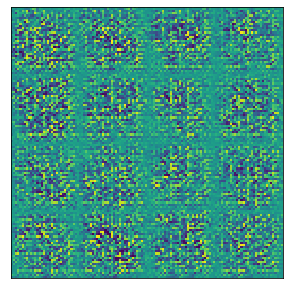

In [6]:
bs = 16
msg_size = 32

model = ReverseAE(msg_size, img_channels=1)
model = model.to('cuda')

for _ in range(0):
    model.configure_optim(lr=0.001, noise_size=0.5)
    X = model.sample(bs=128)
    loss, info = model.optim_step([X, X])

%matplotlib inline
model(16).imshow(5)

In [7]:
msg_size = 32
model = ReverseAE(msg_size, img_channels=1)
model = model.to('cuda')

<IPython.core.display.Javascript object>


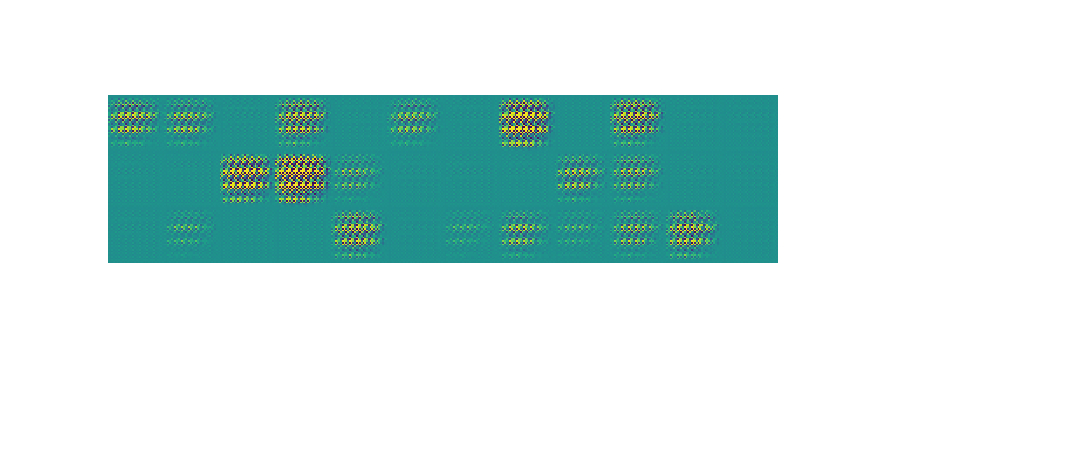

KeyboardInterrupt: 

In [10]:
%matplotlib notebook

epochs = 5
model.configure_optim(lr=0.001, noise_size=1)

msgs = model.sample(36)

with vis.fig([12, 5]) as ctx, mp.fit(
    model=model,
    its=512 * epochs,
    data_gen=model.get_data_gen(bs=128),
) as fit:
#     fit.join()
    for i in fit.wait:
#         epoch = fit.it // epochs
#         model.configure_optim(lr=0.001, noise_size=0.5)

        if i % 500 == 0:
#                 imgs = X[:36].to('cuda')

#                 msg = model.decoder(imgs)
#                 pred_img = model.encoder(msg)

#             ctx.clear()
#                 T.cat([
#                     imgs.reshape    (1, 4, 3, 3, 1, 28, 28),
#                     pred_img.reshape(1, 4, 3, 3, 1, 28, 28),
#                 ]).imshow()
            model.encoder(msgs).reshape(3, 12, 1, 32, 32).imshow()

In [ ]:
%matplotlib inline
model(64).imshow()